Explain-model test metrics: MAE=63.34 RMSE=175.73 R2=0.203 | params: {'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 5, 'random_state': 42, 'n_jobs': -1}


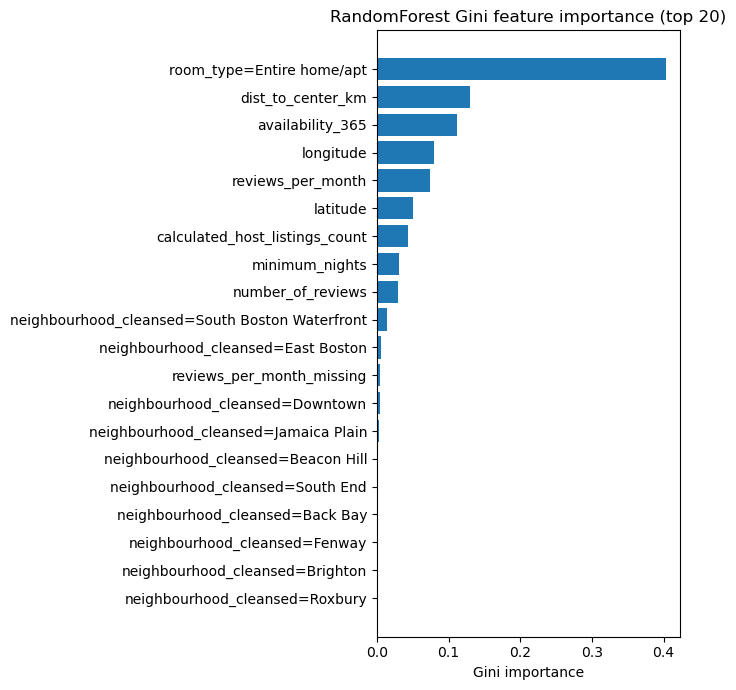

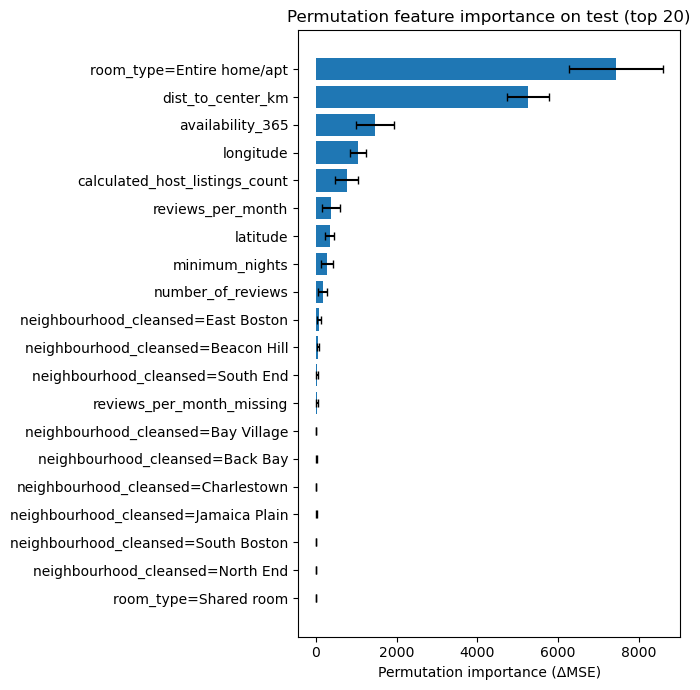

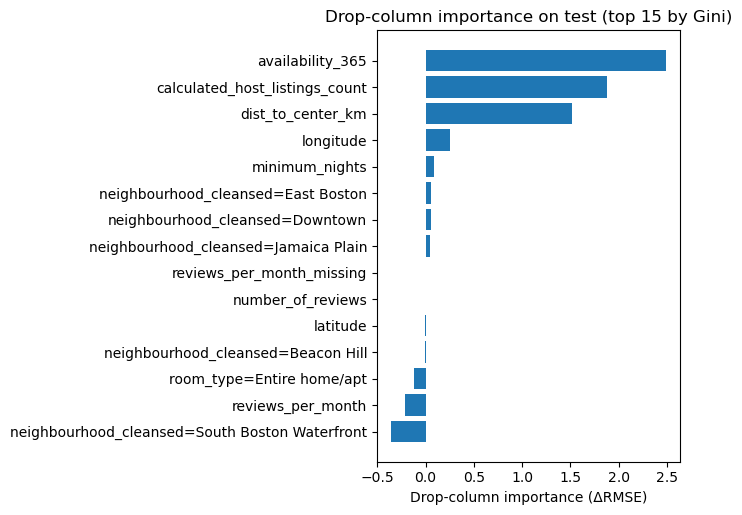

SHAP version: 0.47.2


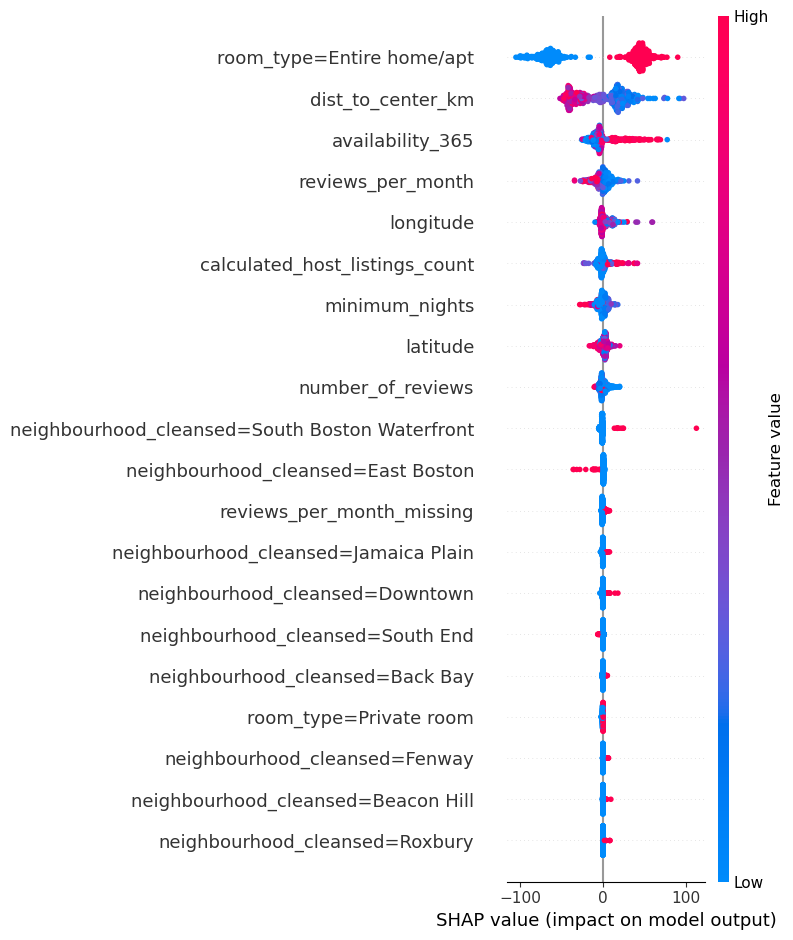

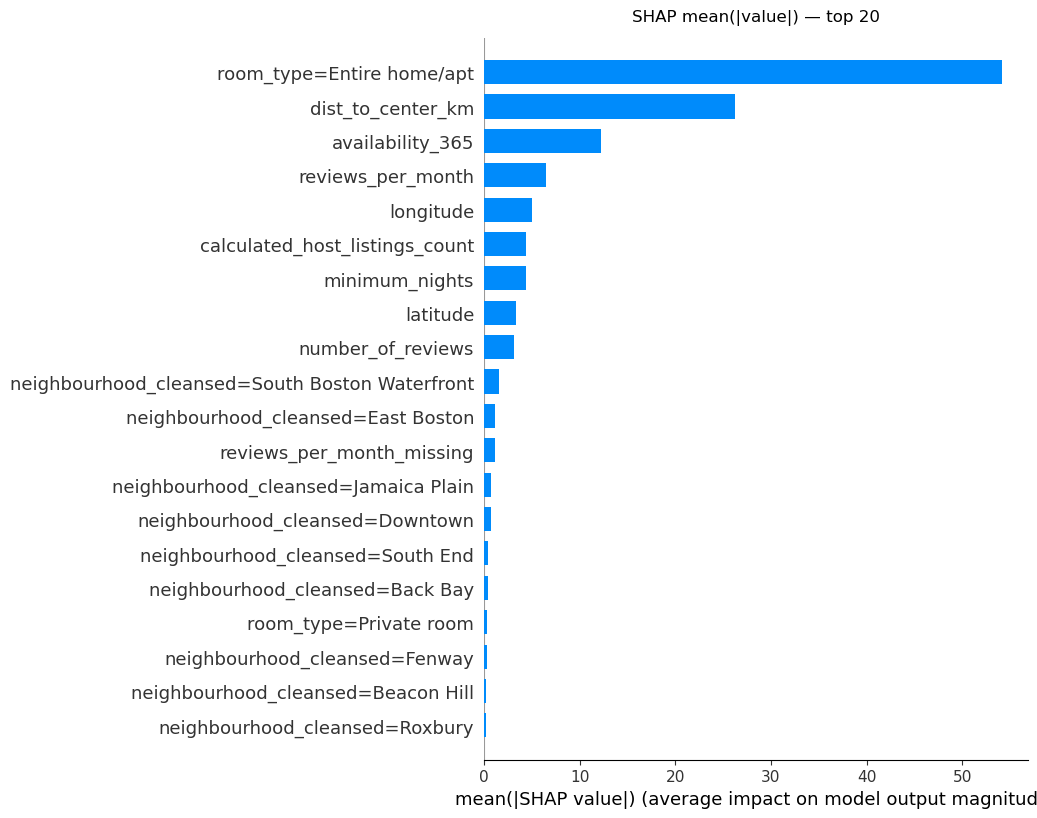

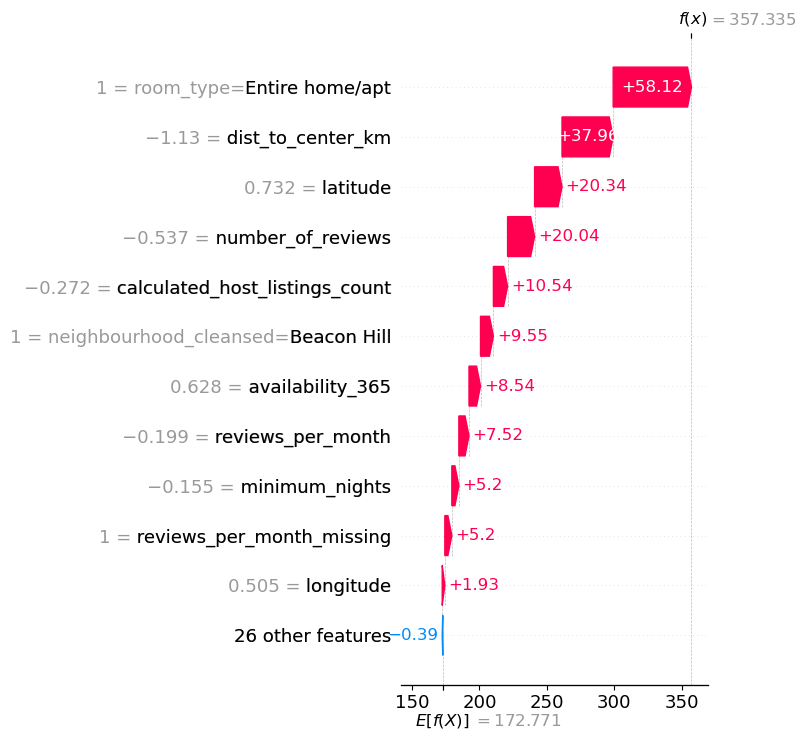

In [7]:
import json, warnings, ast
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

ROOT = Path('..')
RES  = ROOT/'results'
FIGS = ROOT/'figures'
RES.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)

FIG_DPI = 300
plt.rcParams.update({'savefig.dpi': FIG_DPI, 'figure.figsize': (7,4)})

X_train = np.load(RES/'X_train.npy'); y_train = np.load(RES/'y_train.npy')
X_val   = np.load(RES/'X_val.npy');   y_val   = np.load(RES/'y_val.npy')
X_test  = np.load(RES/'X_test.npy');  y_test  = np.load(RES/'y_test.npy')
with open(RES/'feature_names.json','r', encoding='utf-8') as f:
    feature_names = json.load(f)

X_tr = np.vstack([X_train, X_val])
y_tr = np.concatenate([y_train, y_val])

warnings.filterwarnings("ignore", category=UserWarning)

def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

rf_params = {"n_estimators": 300, "max_depth": 10, "min_samples_leaf": 5,
             "random_state": 42, "n_jobs": -1}

best_csv = RES/'best_model_test_scores.csv'
if best_csv.exists():
    try:
        df_best = pd.read_csv(best_csv)
        if 'best_model' in df_best.columns and str(df_best.loc[0,'best_model']) == 'RandomForest':
            if 'best_params' in df_best.columns and isinstance(df_best.loc[0,'best_params'], str):
                parsed = ast.literal_eval(df_best.loc[0,'best_params'])
                for k in ['n_estimators','max_depth','min_samples_leaf','random_state']:
                    if k in parsed: rf_params[k] = parsed[k]
    except Exception:
        pass

rf = RandomForestRegressor(**rf_params)
rf.fit(X_tr, y_tr)

y_pred_test = rf.predict(X_test)
report = {
    "model": "RandomForest(final_explain)",
    "test_MAE": float(mean_absolute_error(y_test, y_pred_test)),
    "test_RMSE": float(rmse(y_test, y_pred_test)),
    "test_R2": float(r2_score(y_test, y_pred_test)),
    "rf_params_used": rf_params
}
pd.DataFrame([report]).to_csv(RES/'explain_model_test_scores.csv', index=False)
print(f"Explain-model test metrics: MAE={report['test_MAE']:.2f} RMSE={report['test_RMSE']:.2f} "
      f"R2={report['test_R2']:.3f} | params: {rf_params}")

gini_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)
gini_imp.to_csv(RES/'importance_gini.csv', index=False)

topN = min(20, len(feature_names))
plt.figure(figsize=(7, max(3, 0.35*topN)))
plt.barh(gini_imp["feature"].head(topN)[::-1], gini_imp["importance"].head(topN)[::-1])
plt.xlabel("Gini importance")
plt.title(f"RandomForest Gini feature importance (top {topN})")
plt.tight_layout()
plt.savefig(FIGS/'fig_importance_gini.png')
plt.show()

perm = permutation_importance(
    rf, X_test, y_test,
    scoring="neg_mean_squared_error",
    n_repeats=10, random_state=42, n_jobs=-1
)
perm_imp = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm.importances_mean,
    "importance_std":  perm.importances_std
}).sort_values("importance_mean", ascending=False)
perm_imp.to_csv(RES/'importance_permutation.csv', index=False)

plt.figure(figsize=(7, max(3, 0.35*topN)))
plt.barh(perm_imp["feature"].head(topN)[::-1], perm_imp["importance_mean"].head(topN)[::-1],
         xerr=perm_imp["importance_std"].head(topN)[::-1], capsize=3)
plt.xlabel("Permutation importance (ΔMSE)")
plt.title(f"Permutation feature importance on test (top {topN})")
plt.tight_layout()
plt.savefig(FIGS/'fig_importance_permutation.png')
plt.show()

top_k = min(15, len(feature_names))
cand_idx = [feature_names.index(f) for f in gini_imp["feature"].head(top_k)]
base_rmse = rmse(y_test, rf.predict(X_test))

rows = []
for j in cand_idx:
    keep = [i for i in range(X_tr.shape[1]) if i != j]
    rf_drop = RandomForestRegressor(**rf_params)
    rf_drop.fit(X_tr[:, keep], y_tr)
    y_pred_drop = rf_drop.predict(X_test[:, keep])
    rows.append({
        "feature": feature_names[j],
        "rmse_increase": rmse(y_test, y_pred_drop) - base_rmse
    })

drop_imp = pd.DataFrame(rows).sort_values("rmse_increase", ascending=False)
drop_imp.to_csv(RES/'importance_dropcolumn_topk.csv', index=False)

plt.figure(figsize=(7, max(3, 0.35*len(drop_imp))))
plt.barh(drop_imp["feature"][::-1], drop_imp["rmse_increase"][::-1])
plt.xlabel("Drop-column importance (ΔRMSE)")
plt.title(f"Drop-column importance on test (top {top_k} by Gini)")
plt.tight_layout()
plt.savefig(FIGS/'fig_importance_dropcolumn.png')
plt.show()

try:
    import shap
    print("SHAP version:", shap.__version__)

    explainer = shap.TreeExplainer(rf)
    rng = np.random.RandomState(0)
    test_idx = rng.choice(X_test.shape[0], size=min(600, X_test.shape[0]), replace=False)
    X_test_sub = X_test[test_idx]
    shap_values = explainer.shap_values(X_test_sub)
    shap_vals = np.array(shap_values)

    plt.figure(figsize=(8,6))
    shap.summary_plot(shap_vals, X_test_sub, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig(FIGS/'fig_shap_beeswarm.png', dpi=FIG_DPI)
    plt.show()

    plt.figure(figsize=(8,6))
    shap.summary_plot(shap_vals, X_test_sub, feature_names=feature_names,
                      plot_type='bar', show=False, max_display=20)
    plt.title("SHAP mean(|value|) — top 20", pad=12)
    plt.gcf().subplots_adjust(top=0.88, bottom=0.12, left=0.30, right=0.98)
    plt.savefig(FIGS/'fig_shap_bar_top20.png', dpi=FIG_DPI)
    plt.show()

    i = 0
    exp_i = shap.Explanation(
        values=shap_vals[i],
        base_values=explainer.expected_value,
        data=X_test_sub[i],
        feature_names=feature_names
    )
    plt.figure(figsize=(8,6))
    shap.plots.waterfall(exp_i, max_display=12, show=False)
    plt.tight_layout()
    plt.savefig(FIGS/f'fig_shap_waterfall_sample_{int(test_idx[i])}.png', dpi=FIG_DPI)
    plt.show()

    rows = []
    k = min(5, X_test_sub.shape[0])
    for si in range(k):
        for j, fname in enumerate(feature_names):
            rows.append({
                "sample_local_index": si,
                "feature": fname,
                "feature_value": float(X_test_sub[si, j]),
                "shap_value": float(shap_vals[si, j])
            })
    pd.DataFrame(rows).to_csv(RES/'shap_local_top5_samples.csv', index=False)

except Exception as e:
    print("[SHAP] skipped:", e)